In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy import interpolate
from netCDF4 import Dataset
import wrf as wrfpy

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
import os, sys
#sys.path.append('../../../')
module_path = os.path.join(os.environ['HOME'],'a2e-mmc')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_spectrum
from mmctools.helper_functions import calc_wind, theta, model4D_calcQOIs, model4D_spatial_spectra, model4D_spatial_cospectra, model4D_spatial_pdfs
from mmctools.wrf.utils import wrfout_seriesReader 

In [5]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16

# SWIFT Perturbation Methods Study 2013-11-08 CBL comparison: 
# Data analysis (template)

Simulation name and directory, and name of virtual towers

In [6]:
modeldatapath = '/glade/scratch/hawbecke/WRF/SWiFT_20131108_PertMethodsGroup/TPert_CBL_18z-20z/'
#modeldatapath = '/glade/scratch/hawbecke/WRF/SWiFT_20131108_PertMethodsGroup/CBL_18Z-20z/'
#modeldatapath = '/glade/scratch/hawbecke/WRF/SWiFT_20131108_PertMethodsGroup/NoPert_CBL_18z-20z/'
modeldatafilter = 'wrfout_d02_2013-11-08_[12][89]:[0-5][0-9]:00'
#modeldatafilter = 'wrfout_d02_2013-11-08_18:[0-5][0-9]:00'
#modeldatafilter = 'wrfout_d02_2013-11-08_18:00:00'
modelprocessedpath = '/glade/scratch/jsauer/A2E-MMC/PMIC1/ASSESSMENT/TPert_CBL_18z-20z/'
#modelprocessedpath = '/glade/scratch/jsauer/A2E-MMC/PMIC1/ASSESSMENT/NOPERT/'
#modelprocessedfile = 'WRF_d02-60minFull-wrfout-xarray.nc'
modelprocessedfile = 'WRF_d02-120minFull-wrfout-xarray.nc'
modelprocessedname = '{:s}{:s}'.format(modelprocessedpath,modelprocessedfile)
modelprocessedfigure = 'Microscale_AssessmentMontage120minutes.png'
modelprocessedfetch = 'Microscale_AssessmentFetch120minutes.png'

# Names of output files

In [7]:
simname='PMIC-1'
output_figure = os.path.join(modelprocessedpath,modelprocessedfigure)
output_fetch = os.path.join(modelprocessedpath,modelprocessedfetch)
output_spectra = os.path.join(modelprocessedpath,simname+'_spectra.nc')
output_stats = os.path.join(modelprocessedpath,simname+'_stats.nc')

# Part 1: Load, process 4-D data

### 1a. Model-specific data loader

<font size=4><font color="red">**Define code-specific reader that returns a standardized xarrays DataSet:**</font></font>

- with dimensions `datetime`,`nz`,`ny`,`nx`
- with coordinate variables `*datetime`,`x`,`y`,`z`,`zsurface`,`lat`,`lon`
- standard column names `u`, `v`, `w`, `theta`,`p`,`wspd`,`wdir`
- standard SI units of [m], [m/s], and [K]

### 1b. If necessary construct Dataset from raw model outputs

In [8]:
if os.path.exists(modelprocessedname):
    print('{:s} exists, establishing reference to processed-dataset directly...'.format(modelprocessedname))
    %time ds=xr.open_mfdataset(modelprocessedname,chunks={'datetime': 10},combine='nested',concat_dim='datetime')
    #CPU times: user 19.7 ms, sys: 1.64 ms, total: 21.4 ms
    #Wall time: 21.4 ms     ### JAS note: this is fast because nothing is actually read or loaded into memory (lazy evaluation)
else:
    print('{:s} does not exist, reading 4-d model outputs and destaggering from wrfout(s)...'.format(modelprocessedname))
    %time ds = wrfout_seriesReader(modeldatapath,modeldatafilter,specified_heights=None)
    #%time ds = wrfout_seriesReader(modeldatapath,modeldatafilter,specified_heights=[4.0, 8.0, 12.0, 20.0, 40.0, 60.0, 80.0, 100.0, 150.0, 200.0])
    #CPU times: user 6min 6s, sys: 5min, total: 11min 6s
    #Wall time: 13min 4s   ###JAS this was for 60 time instances

/glade/scratch/jsauer/A2E-MMC/PMIC1/ASSESSMENT/TPert_CBL_18z-20z/WRF_d02-120minFull-wrfout-xarray.nc does not exist, reading 4-d model outputs and destaggering from wrfout(s)...
Finished opening/concatenating datasets...
Establishing coordinate variables, x,y,z, zSurface...
Destaggering data variables, u,v,w...
Extracting data variables, p,theta...
Calculating derived data variables, wspd, wdir...
CPU times: user 9min 19s, sys: 3min 43s, total: 13min 3s
Wall time: 15min 17s


## 2. Data processing

### 2a. Calculation of spanwise mean and perturbations for all streamwise locations and all variables of interest

In [9]:
if os.path.exists(modelprocessedname):
    print('{:s} exists, skipping calculation of quantities of interest...'.format(modelprocessedname))
else:
    print('{:s} does not exist, calculating of quantities of interest...'.format(modelprocessedname))
    %time ds=model4D_calcQOIs(ds,'ny')
    #CPU times: user 3min 3s, sys: 8min 20s, total: 11min 24s
    #Wall time: 17min 37s ###JAS this was for 60 time instances

#### So here is the processed dataset...
#ds

/glade/scratch/jsauer/A2E-MMC/PMIC1/ASSESSMENT/TPert_CBL_18z-20z/WRF_d02-120minFull-wrfout-xarray.nc does not exist, calculating of quantities of interest...
CPU times: user 4min 42s, sys: 8min 38s, total: 13min 20s
Wall time: 14min


### 2b. Save full processed dataset, if desired

In [10]:
saveProcessedDataSetSwitch=True
if os.path.exists(modelprocessedname):
    print('{:s} exists, no need to save...'.format(modelprocessedname))
else:
    if saveProcessedDataSetSwitch:
        %time ds.to_netcdf(modelprocessedname, mode='w', format='NETCDF4', unlimited_dims='datetime', compute=True)
        #CPU times: user 1.34 s, sys: 1min 48s, total: 1min 50s
        #Wall time: 5min 23s

CPU times: user 2min 8s, sys: 3min 26s, total: 5min 34s
Wall time: 19min 14s


# Specify downstream locations from which to assess turbulence characteristics versus fetch

In [11]:
levels=[5,10,15,30,40]
iLocs=[25,40,120,240,300,360,420,480,540,700,900]

# Calculate windspeed-based spectra

In [12]:
%%time
vertLevels=[15]
fld='wspd' #'theta'
fldMean='UMean' #'thetaMean'
f, Puuf = model4D_spatial_spectra(ds,'ny',vertLevels,iLocs,fld,fldMean)

##Past-timing
#CPU times: user 2 s, sys: 1.32 s, total: 3.31 s
#Wall time: 17.9 s
##New-timing: From 60-time instance reload of the full procesed datafile
#CPU times: user 1.49 s, sys: 184 ms, total: 1.67 s
#Wall time: 4.42 s

Averaging spectra over 120 time-instances
CPU times: user 2.74 s, sys: 85 ms, total: 2.83 s
Wall time: 2.88 s


# Calculate cospectra

In [13]:
%%time
vertLevels=[15]
f, Puwf = model4D_spatial_cospectra(ds,'ny',vertLevels,iLocs,'wspd','UMean','w','wMean')
f, Pwtf = model4D_spatial_cospectra(ds,'ny',vertLevels,iLocs,'w','wMean','theta','thetaMean')

Averaging spectra over 120 time-instances
Averaging spectra over 120 time-instances
CPU times: user 11.2 s, sys: 139 ms, total: 11.3 s
Wall time: 11.3 s


# Calculate w-perturbation distribution and distribution higher-order moments

In [14]:
%%time
from scipy.stats import skew,kurtosis

bins_vector = np.linspace(-5.0,5.0,240)
fld='w' #'theta'
fldMean='wMean' #'thetaMean'
hist_cum, bin_edges, sk_vec, kurt_vec = model4D_spatial_pdfs(ds,'ny',vertLevels,iLocs,fld,fldMean,bins_vector)

##Past-timing
#CPU times: user 1min 42s, sys: 2min 16s, total: 3min 59s
#Wall time: 8min 3s
##New-timing: From 60-time instance reload of the full procesed datafile
#CPU times: user 37.6 s, sys: 1min 54s, total: 2min 31s
#Wall time: 2min 44s
##Newest-timing: From 120-time instance reload of the full procesed datafile
#Accumulating statistics over 120 time-instances
#CPU times: user 8.8 s, sys: 2.35 s, total: 11.1 s
#Wall time: 19.6 s


Accumulating statistics over 120 time-instances
CPU times: user 2.66 s, sys: 47.5 ms, total: 2.71 s
Wall time: 2.72 s


# Create montage simulation summary figure of instantaneous windspeed, windspeed energy spectra, cospectra, and w-perturbation distributions

ax[0] setup complete...
ax[1] setup complete...
ax[2] setup complete...
ax[3] setup complete...
ax[4] setup complete...
ax[5] setup complete...
ax[6] setup complete...
ax[7] setup complete...
ax[8] setup complete...
ax[9] setup complete...
ax[10] setup complete...
0 30
ax[11] setup complete...
ax[12] setup complete...
ax[13] setup complete...
ax[14] setup complete...
CPU times: user 1.47 s, sys: 167 ms, total: 1.64 s
Wall time: 2.58 s


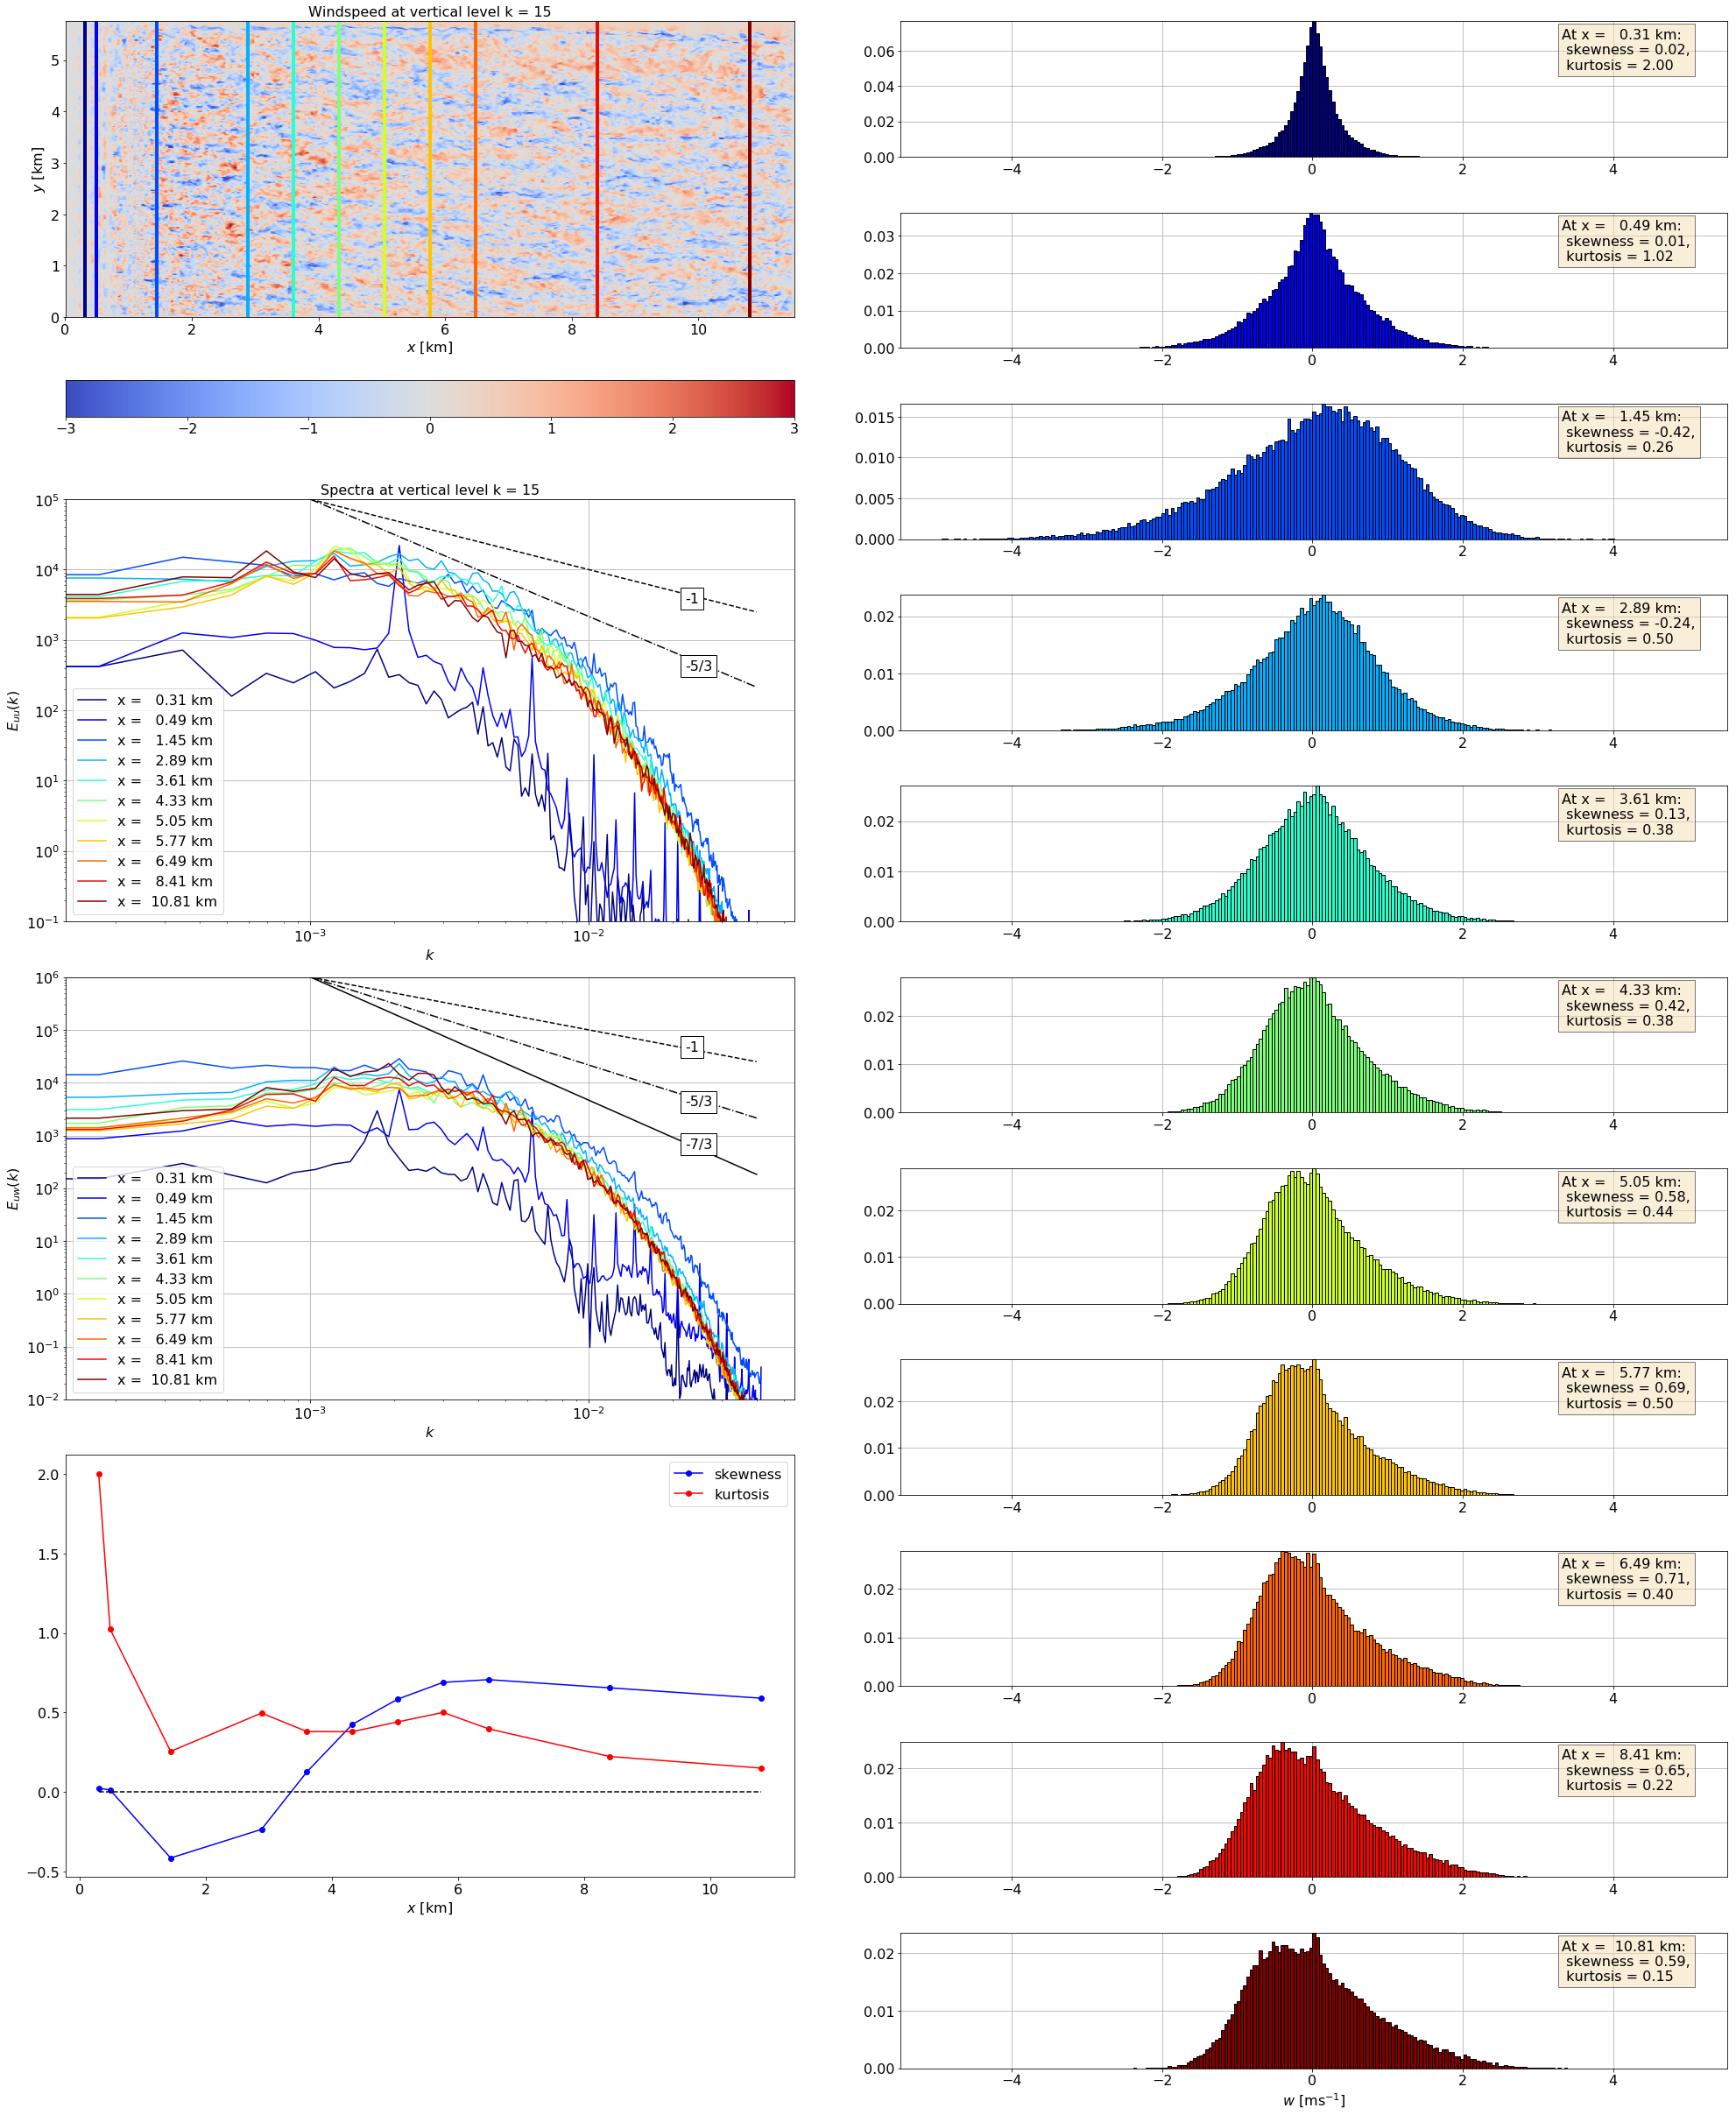

In [15]:
%%time
from matplotlib.gridspec import GridSpec

fntSize = 16
vertLevel = levels[2]
datetime_to_plot = 2

###Try using grispec to layout multiple plots in a single plot frame....
fig = plt.figure(figsize=(34,len(iLocs)*4))
gs=GridSpec(len(iLocs)*4,34)

ax=[]
cnt_i=0
for iLoc in iLocs:
    ax.append(fig.add_subplot(gs[cnt_i*4:(cnt_i+1)*4-1,17:34]))   #The histograms
    print('ax[{:d}] setup complete...'.format(cnt_i))
    cnt_i=cnt_i+1
numLeftColumnPlots = 6
axhgt = np.floor(((len(iLocs)+1)*4-1)/(numLeftColumnPlots+2)).astype(int)
print(0*axhgt,numLeftColumnPlots*axhgt)
ax.append(fig.add_subplot(gs[0*axhgt:2*axhgt-1,0:15]))  # The pcolormesh with overlayed lines of fetch
axpc=cnt_i
print('ax[{:d}] setup complete...'.format(axpc))
cnt_i=cnt_i+1
ax.append(fig.add_subplot(gs[2*axhgt:4*axhgt-1,0:15]))  # The spectra plot
axsp=cnt_i
print('ax[{:d}] setup complete...'.format(axsp))
cnt_i=cnt_i+1

flux_vs_fetch=False
if flux_vs_fetch:
    ax.append(fig.add_subplot(gs[4*axhgt:5*axhgt-1,0:15]))  # The TKE vs. fetch plot
    axTKE=cnt_i
    print('ax[{:d}] setup complete...'.format(axTKE))
    cnt_i=cnt_i+1
    ax.append(fig.add_subplot(gs[5*axhgt:6*axhgt-1,0:15]))  # The <U'w'> vs. fetch plot
    axUw=cnt_i
    print('ax[{:d}] setup complete...'.format(axUw))
    cnt_i=cnt_i+1
    ax.append(fig.add_subplot(gs[6*axhgt:7*axhgt-1,0:15]))  # The <w'th'> vs. fetch plot
    axwth=cnt_i
    print('ax[{:d}] setup complete...'.format(axwth))
    cnt_i=cnt_i+1
    ax.append(fig.add_subplot(gs[7*axhgt:8*axhgt-1,0:15]))  # The stats plot
    axst=cnt_i
    print('ax[{:d}] setup complete...'.format(axst))
    cnt_i=cnt_i+1
else:
    ax.append(fig.add_subplot(gs[4*axhgt:6*axhgt-1,0:15]))  # The stats plot
    axcosp=cnt_i
    print('ax[{:d}] setup complete...'.format(axcosp))
    cnt_i=cnt_i+1
    ax.append(fig.add_subplot(gs[6*axhgt:8*axhgt-1,0:15]))  # The stats plot
    axst=cnt_i
    print('ax[{:d}] setup complete...'.format(axst))
    cnt_i=cnt_i+1

########----  Multiple time instance histogram for each fetch-wise location in iLocs
n = len(iLocs)
colors = plt.cm.jet(np.linspace(0,1,n))
cnt_lvl=0
cnt_i=0
props = dict(boxstyle='square', facecolor='wheat', alpha=0.5)  #Properties for text boxes
for iLoc in iLocs:
    max_histval = np.amax(hist_cum[cnt_lvl,cnt_i,:]/(ds.dims['datetime']*ds.dims['ny']))
    ax[cnt_i].grid(zorder=0)
    ### bins_vector[:-1] and bin_edges are equivalent
    im=ax[cnt_i].bar(bins_vector[:-1]+np.diff(bins_vector)/2, hist_cum[cnt_lvl,cnt_i,:]/(ds.dims['datetime']*ds.dims['ny']), 
                     width=np.diff(bins_vector),color=colors[cnt_i], ec="k", align="edge",zorder=3)
    #ax[cnt_i].set_title('At x = {:8.2f} m: skewness = {:4.2f}, kurtosis = {:4.2f}'.format(ds['x'].isel(nx=iLoc).values,
    #                                                                                      sk_vec[cnt_lvl,cnt_i],kurt_vec[cnt_lvl,cnt_i]),
    #                    fontsize=fntSize)
    textstr ='At x = {:6.2f} km:\n skewness = {:4.2f},\n kurtosis = {:4.2f}'.format(ds['x'].isel(nx=iLoc).values/1e3,
                                                                                sk_vec[cnt_lvl,cnt_i],kurt_vec[cnt_lvl,cnt_i])
    ax[cnt_i].text(0.80, 0.95, textstr, transform=ax[cnt_i].transAxes, fontsize=16,verticalalignment='top', bbox=props)
    ax[cnt_i].set_ylim(0.0,max_histval)
    ax[cnt_i].set_ylim(0.0,max_histval)
    if(cnt_i is len(iLocs)-1):
        ax[cnt_i].set_xlabel(r'$w`$ $[\mathrm{ms^{-1}}]$',fontsize=fntSize)
    cnt_i=cnt_i+1

########----  The pcolormesh and overlayed fetch lines plot
im = ax[axpc].pcolormesh(ds.x/1e3,ds.y/1e3,
                    ds['wspd'].isel(datetime=datetime_to_plot,nz=vertLevel)-ds['UMean'].isel(datetime=datetime_to_plot,nz=vertLevel),
                    zorder=1,cmap=plt.cm.coolwarm,vmin=-3, vmax=3)
ax[axpc].set_title('Windspeed at vertical level k = {:d}'.format(vertLevel),fontsize=fntSize)
ax[axpc].set_ylabel(r'$y$ $[\mathrm{km}]$',fontsize=fntSize)
ax[axpc].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
fig.colorbar(im, ax=ax[axpc], orientation='horizontal',pad=0.15)

colors = plt.cm.jet(np.linspace(0,1,n))
cnt_i=0
for iLoc in iLocs: 
    im=ax[axpc].plot(ds.x.isel(nx=iLoc).values/1e3*np.ones(len(ds.y)),ds.y/1e3,'-',linewidth=4,color=colors[cnt_i],label='iLoc')
    cnt_i=cnt_i+1

########----  The spectra versus fetch plot
xRng = np.linspace(1e-3,4e-2,1000);
y53 = 1e0*xRng**(-5/3);
y1 = 1e2*xRng**(-1);

n = len(iLocs)
colors = plt.cm.jet(np.linspace(0,1,n))

cnt_i=0
for iLoc in iLocs:
    if cnt_i == len(iLocs)-1:
        ax[axsp].plot(xRng,y53,'-.',color='k');
        ax[axsp].plot(xRng,y1,'--',color='k');
    ax[axsp].loglog(f, Puuf[:,cnt_i,:].transpose(),'-',color=colors[cnt_i],label='x = {:6.2f} km'.format(ds['x'].isel(nx=iLoc).values/1e3))
    cnt_i = cnt_i + 1
ax[axsp].grid()
ax[axsp].set_title('Spectra at vertical level k = {:d}'.format(vertLevel),fontsize=fntSize)
#print('k-lowest = {:f}'.format(f[0]*(ds.dims['south_north']*ds.attrs['DX'])))
#print('k-highest = {:f}'.format(f[-1]*(ds.dims['south_north']*ds.attrs['DX'])))
#print('series length = {:d}'.format(nblock))
#ax[axsp].set_ylim([1e-5,5e5])
ax[axsp].set_ylim([1e-1,1e5])
ax[axsp].set_ylabel(r'$E_{uu}(k)$',fontsize=fntSize)
ax[axsp].set_xlabel(r'$k$',fontsize=fntSize)
ax[axsp].legend(loc='lower left',prop=dict(size=fntSize))
props = dict(boxstyle='square', facecolor='white', alpha=1.0)  #Properties for text boxes
ax[axsp].text(0.85, 0.78, '-1', transform=ax[axsp].transAxes, fontsize=16,verticalalignment='top', bbox=props)
ax[axsp].text(0.85, 0.62, '-5/3', transform=ax[axsp].transAxes, fontsize=16,verticalalignment='top', bbox=props)

if flux_vs_fetch:
    ########----  The TKE, <U'w'>, and <w'th'> fetch plot
    n = len(levels)
    colors = plt.cm.gnuplot(np.linspace(0,1,n))
    cnt_k=0
    for lev in levels:
        ax[axTKE].plot(ds.x/1e3,ds['TKE'].sel(nz=lev).mean('ny').mean('datetime').transpose(),
                       color=colors[cnt_k],
                       label='z ~{:6.2f} m AGL'.format(ds['z'].isel(datetime=0,nz=lev,ny=0,nx=0).values))
        ax[axTKE].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
        ax[axUw].plot(ds.x/1e3,ds['Uw'].sel(nz=lev).mean('ny').mean('datetime').transpose(),color=colors[cnt_k])
        ax[axUw].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
        ax[axwth].plot(ds.x/1e3,ds['wth'].sel(nz=lev).mean('ny').mean('datetime').transpose(),color=colors[cnt_k])
        ax[axwth].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
        cnt_k = cnt_k+1
    ax[axTKE].legend(loc='lower center',fontsize=fntSize)
else:
    ########----  The cospectra versus fetch plot
    xRng = np.linspace(1e-3,4e-2,1000);
    y73 = 1e-1*xRng**(-7/3);
    y53 = 1e1*xRng**(-5/3);
    y1 = 1e3*xRng**(-1);
    n = len(iLocs)
    colors = plt.cm.jet(np.linspace(0,1,n))
    cnt_i=0
    for iLoc in iLocs:
        if cnt_i == len(iLocs)-1:
            ax[axcosp].plot(xRng,y73,'-',color='k');
            ax[axcosp].plot(xRng,y53,'-.',color='k');
            ax[axcosp].plot(xRng,y1,'--',color='k');
        ax[axcosp].loglog(f, Puwf[:,cnt_i,:].transpose(),'-',color=colors[cnt_i],label='x = {:6.2f} km'.format(ds['x'].isel(nx=iLoc).values/1e3))
        cnt_i = cnt_i + 1
    ax[axcosp].grid()
    #print('k-lowest = {:f}'.format(f[0]*(ds.dims['south_north']*ds.attrs['DX'])))
    #print('k-highest = {:f}'.format(f[-1]*(ds.dims['south_north']*ds.attrs['DX'])))
    #print('series length = {:d}'.format(nblock))
    #ax[axcosp].set_ylim([1e-5,1e6])
    ax[axcosp].set_ylim([1e-2,1e6])
    ax[axcosp].set_ylabel(r'$E_{uw}(k)$',fontsize=fntSize)
    ax[axcosp].set_xlabel(r'$k$',fontsize=fntSize)
    ax[axcosp].legend(loc='lower left',prop=dict(size=fntSize))
    props = dict(boxstyle='square', facecolor='white', alpha=1.0)  #Properties for text boxes
    ax[axcosp].text(0.85, 0.85, '-1', transform=ax[axcosp].transAxes, fontsize=16,verticalalignment='top', bbox=props)
    ax[axcosp].text(0.85, 0.72, '-5/3', transform=ax[axcosp].transAxes, fontsize=16,verticalalignment='top', bbox=props)
    ax[axcosp].text(0.85, 0.62, '-7/3', transform=ax[axcosp].transAxes, fontsize=16,verticalalignment='top', bbox=props)

########----  The stats versus fetch plot
ax[axst].plot(ds.x.isel(nx=iLocs)/1e3,sk_vec[cnt_lvl,:],'o-',color='b',label='skewness')
ax[axst].plot(ds.x.isel(nx=iLocs)/1e3,kurt_vec[cnt_lvl,:],'o-',color='r',label='kurtosis')
ax[axst].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
ax[axst].legend(loc='upper right',fontsize=fntSize)
ax[axst].plot(ds.x.isel(nx=iLocs)/1e3,np.zeros(ds.x.isel(nx=iLocs).values.shape),'--',color='k',label='skewness = 0 (symmetric), kurtosis = 0 (normal)')

##Past-timing
#CPU times: user 3.9 s, sys: 7.3 s, total: 11.2 s
#Wall time: 2min 4s  

# Save montage figure

In [16]:
print(output_figure)
fig.savefig(output_figure,dpi=200)

/glade/scratch/jsauer/A2E-MMC/PMIC1/ASSESSMENT/TPert_CBL_18z-20z/Microscale_AssessmentMontage120minutes.png


# Create TKE, momentum flux, and sensible heat flux versus fetch figure

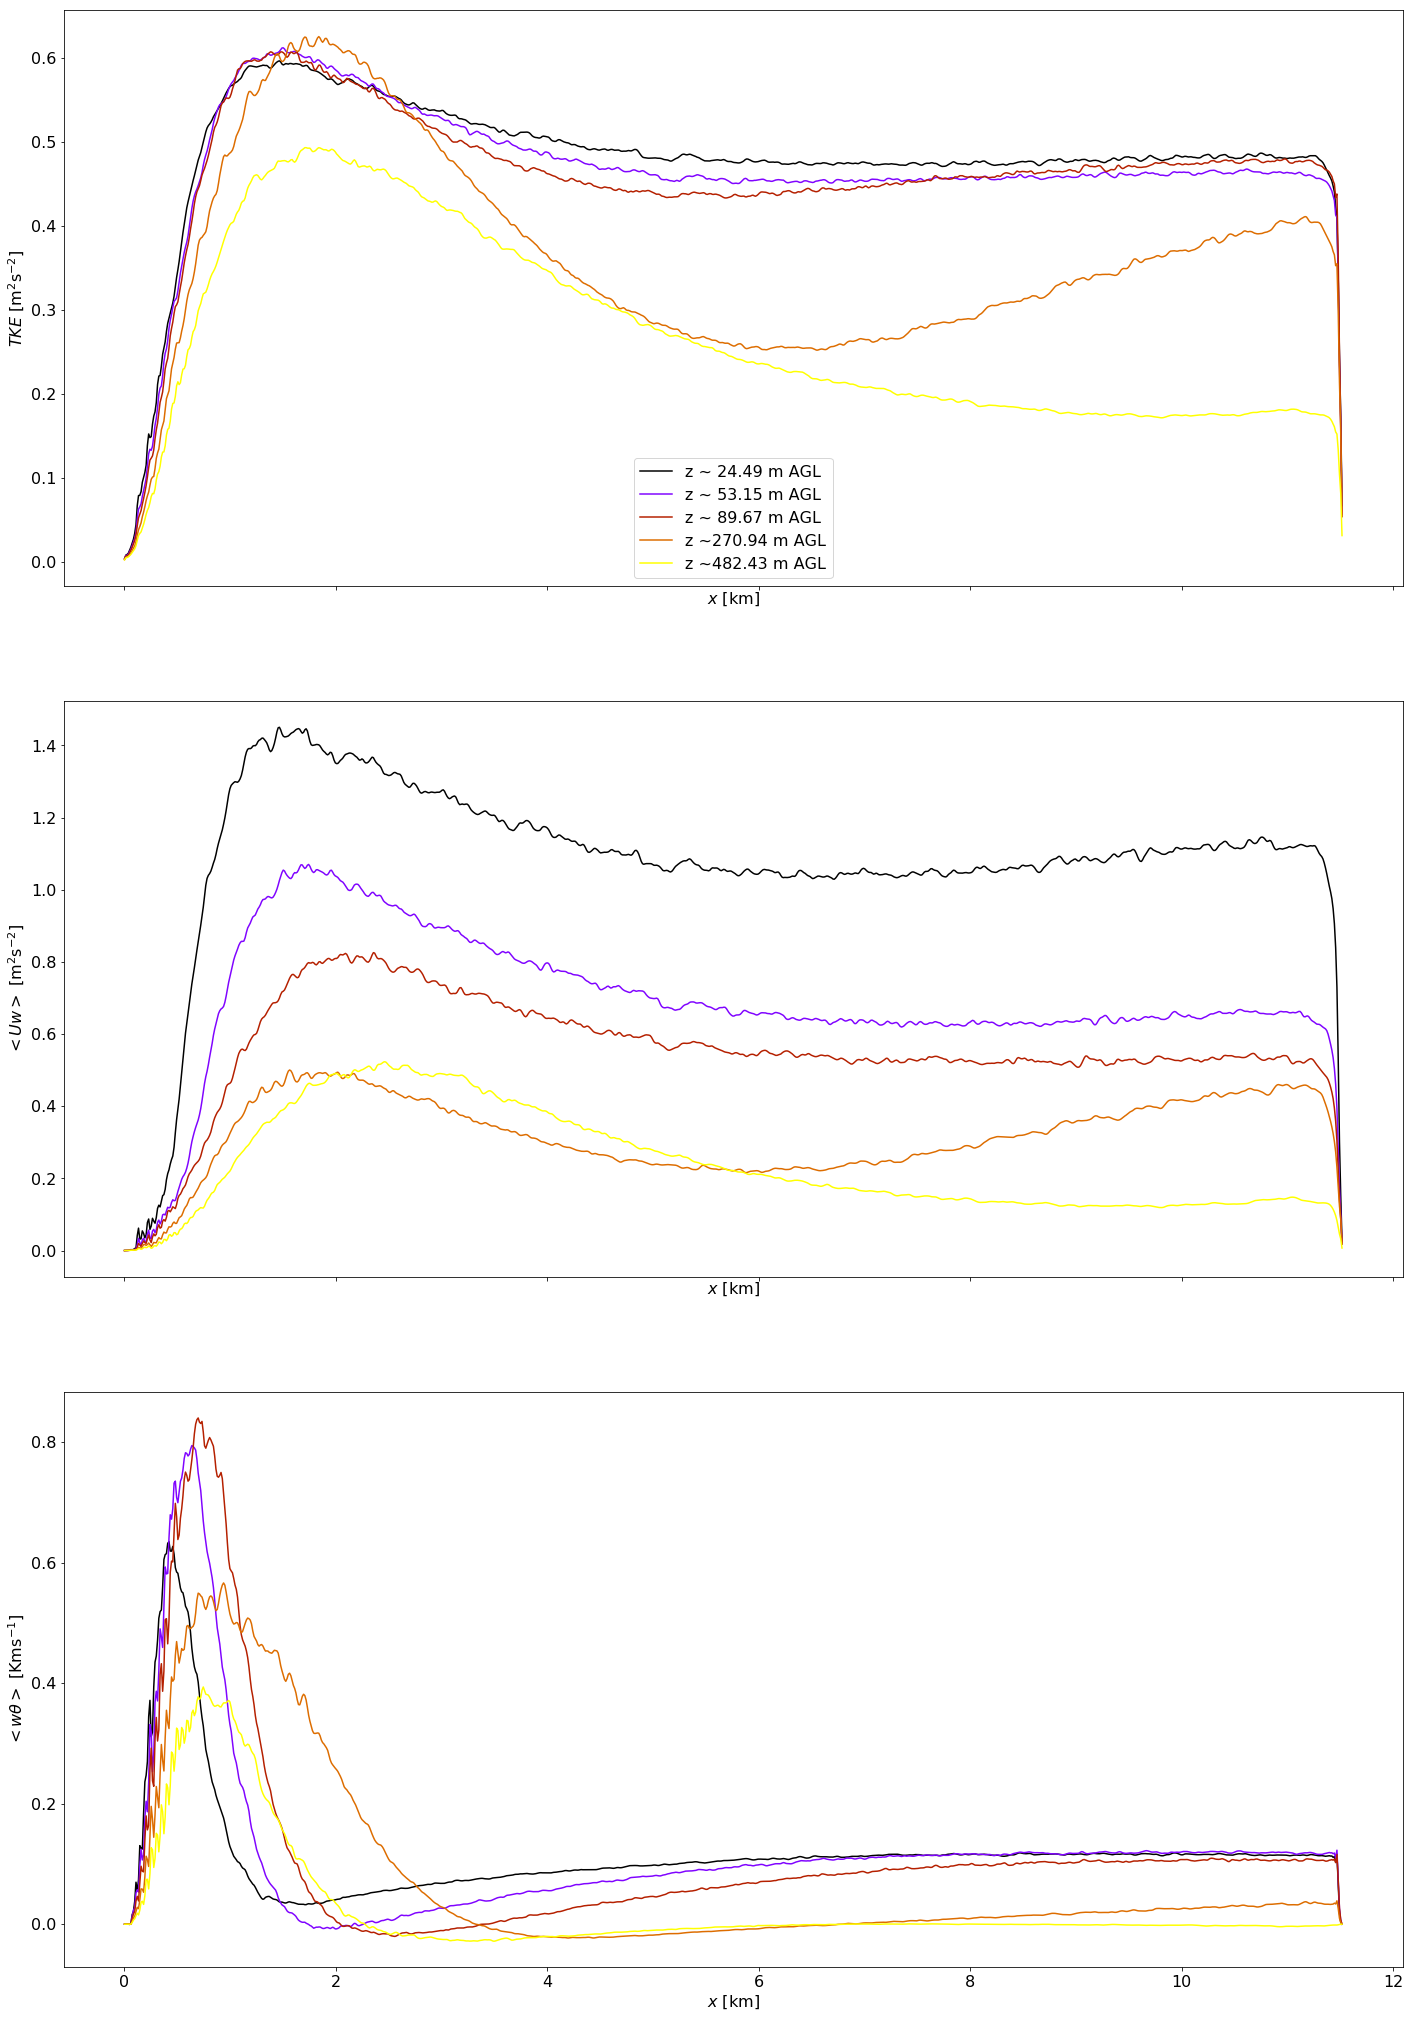

In [17]:
fig, ax = plt.subplots(3,1, figsize=(24, 36), sharex=True)
axTKE=0
axUw=1
axwth=2
########----  The TKE, <U'w'>, and <w'th'> fetch plot
n = len(levels)
colors = plt.cm.gnuplot(np.linspace(0,1,n))
cnt_k=0
for lev in levels:
    ax[axTKE].plot(ds.x/1e3,ds['TKE'].sel(nz=lev).mean('ny').mean('datetime').transpose(),
                   color=colors[cnt_k],
                   label='z ~{:6.2f} m AGL'.format(ds['z'].isel(datetime=0,nz=lev,ny=0,nx=0).values))
    ax[axTKE].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    ax[axTKE].set_ylabel(r'$TKE$ $[\mathrm{m^2 s^{-2}}]$',fontsize=fntSize)
    ax[axUw].plot(ds.x/1e3,ds['Uw'].sel(nz=lev).mean('ny').mean('datetime').transpose(),color=colors[cnt_k])
    ax[axUw].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    ax[axUw].set_ylabel(r'$<Uw>$ $[\mathrm{m^2 s^{-2}}]$',fontsize=fntSize)
    ax[axwth].plot(ds.x/1e3,ds['wth'].sel(nz=lev).mean('ny').mean('datetime').transpose(),color=colors[cnt_k])
    ax[axwth].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    ax[axwth].set_ylabel(r'$<w\theta>$ $[\mathrm{Km s^{-1}}]$',fontsize=fntSize)
    cnt_k = cnt_k+1
    ax[axTKE].legend(loc='lower center',fontsize=fntSize)

# Save fetch-based assessment figure

In [18]:
print(output_fetch)
fig.savefig(output_fetch,dpi=200)

/glade/scratch/jsauer/A2E-MMC/PMIC1/ASSESSMENT/TPert_CBL_18z-20z/Microscale_AssessmentFetch120minutes.png


# Create xarray datasets for the spectra and distrbution metrics, then save them to file for sharing amongst the group

In [19]:
#### Create an xarrays dataset of the reported assessement metrics
#### spectra
spectra_ds = xr.Dataset()
#### PDFs
stats_ds = xr.Dataset()
#print(bins_vector[:-1])
#print(bin_edges)
#hist_cum.shape
#sk_vec.shape
#kurt_vec.shape


In [20]:
spectra_dims_dict = {
        'dim_0':'vert_levels',
        'dim_1':'x',
        'dim_2': 'f',
}
stats_dims_dict = {
        'dim_0':'vert_levels',
        'dim_1':'x',
        'dim_2': 'bins',
}
spectra_ds['Puuf'] = xr.DataArray(Puuf)
spectra_ds['Puwf'] = xr.DataArray(Puwf)
spectra_ds['f'] = xr.DataArray(np.squeeze(f),dims=['dim_2'])
spectra_ds = spectra_ds.assign_coords(f=spectra_ds['f'])
spectra_ds = spectra_ds.assign_coords(f=spectra_ds['f'])
spectra_ds = spectra_ds.rename_dims(spectra_dims_dict)
stats_ds['hist_cum']=xr.DataArray(hist_cum)
stats_ds['bins']=xr.DataArray(bins_vector[:-1]+np.diff(bins_vector)/2.0,dims=['dim_2'])
stats_ds['sk_vec']=xr.DataArray(sk_vec,dims=['dim_0','dim_1'])
stats_ds['kurt_vec']=xr.DataArray(kurt_vec,dims=['dim_0','dim_1'])
stats_ds = stats_ds.assign_coords(bins=stats_ds['bins'])
stats_ds = stats_ds.assign_coords(x=ds['x'].isel(nx=iLocs).values)
stats_ds = stats_ds.rename_dims(stats_dims_dict)
print(spectra_ds)
print(stats_ds)

<xarray.Dataset>
Dimensions:  (f: 240, vert_levels: 1, x: 11)
Coordinates:
  * f        (f) float64 0.0 0.0001736 0.0003472 ... 0.04115 0.04132 0.04149
Dimensions without coordinates: vert_levels, x
Data variables:
    Puuf     (vert_levels, x, f) float64 19.02 418.3 719.4 ... 0.007324 0.007385
    Puwf     (vert_levels, x, f) float64 13.6 150.9 294.9 ... 0.005186 0.003935
<xarray.Dataset>
Dimensions:   (bins: 239, vert_levels: 1, x: 11)
Coordinates:
  * bins      (bins) float64 -4.979 -4.937 -4.895 -4.854 ... 4.895 4.937 4.979
  * x         (x) float64 306.0 486.0 1.446e+03 ... 8.406e+03 1.081e+04
Dimensions without coordinates: vert_levels
Data variables:
    hist_cum  (vert_levels, x, bins) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    sk_vec    (vert_levels, x) float64 0.02281 0.01274 -0.4151 ... 0.6549 0.5895
    kurt_vec  (vert_levels, x) float64 1.998 1.024 0.2551 ... 0.2231 0.1501


In [21]:
print(output_spectra)
spectra_ds.to_netcdf(output_spectra, mode='w', format='NETCDF4', compute=True)
print(output_stats)
stats_ds.to_netcdf(output_stats, mode='w', format='NETCDF4', compute=True)

/glade/scratch/jsauer/A2E-MMC/PMIC1/ASSESSMENT/TPert_CBL_18z-20z/PMIC-1_spectra.nc
/glade/scratch/jsauer/A2E-MMC/PMIC1/ASSESSMENT/TPert_CBL_18z-20z/PMIC-1_stats.nc


# Compare microscale domains mean-profiles to observations

In [24]:
TTUdata = '../../datasets/SWiFT/data/TTU_tilt_corrected_20131108-09.csv'
df = pd.read_csv(TTUdata, parse_dates=True, index_col='datetime')
# Calculate wind speed and direction
df['wspd'], df['wdir'] = calc_wind(df)
# Calculate potential temperature
df['theta'] = theta(df['T'],df['p'])
df30 = df.pivot(columns='height',values=['u','v','w','wspd','wdir','theta']).resample('30min').mean().stack()
df30.reset_index(inplace=True)
df30.set_index(['datetime'],inplace=True)
obs_legStrs = []
mod_legStrs = []
datetimeStrs = []
modelHours = [18,19]  #commensurate with model_file_filter
for modelHour in modelHours:
    obs_legStrs.append('Obs-{:d}Z'.format(modelHour))
    mod_legStrs.append('Mod-{:d}Z'.format(modelHour))
    datetimeStrs.append('2013-11-08 {:2d}:00:00'.format(modelHour))
print(obs_legStrs)
print(mod_legStrs)
print(datetimeStrs)

['Obs-18Z', 'Obs-19Z']
['Mod-18Z', 'Mod-19Z']
['2013-11-08 18:00:00', '2013-11-08 19:00:00']


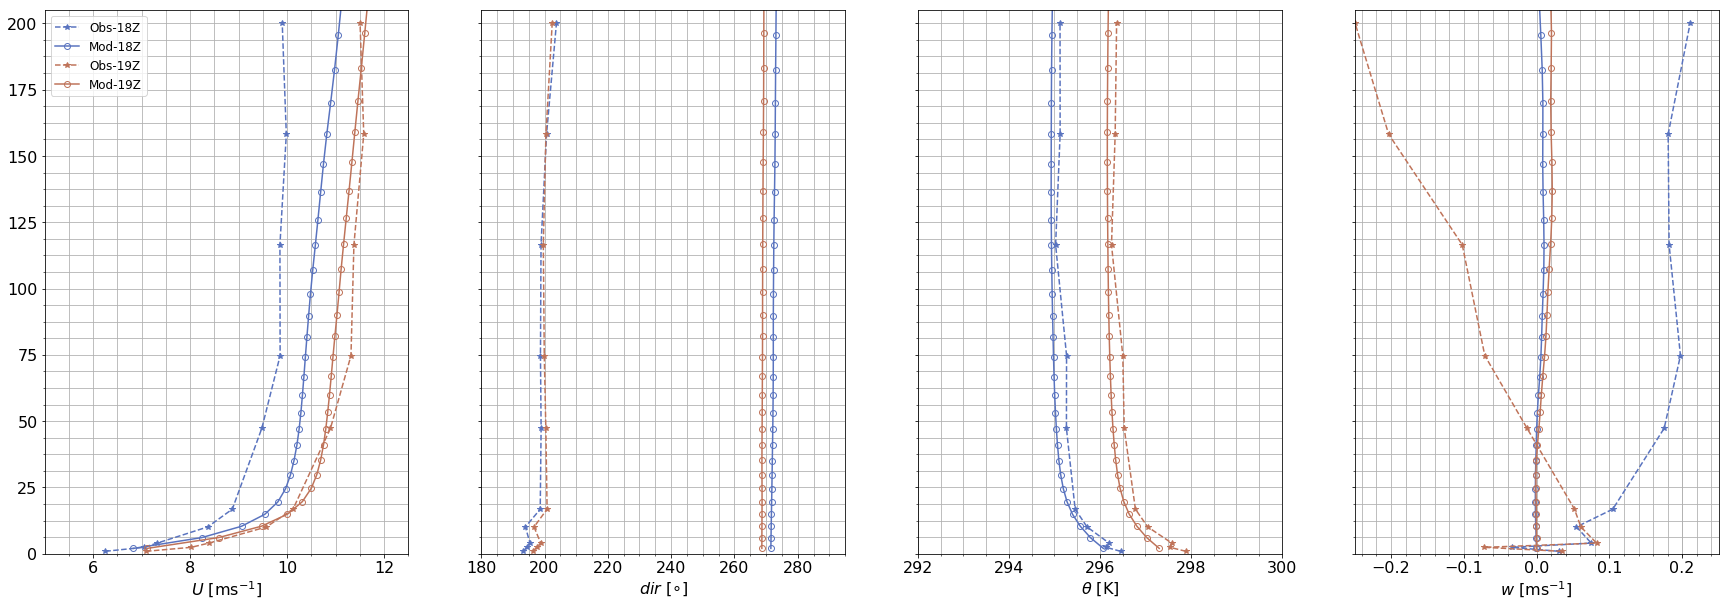

In [25]:
fntSize=16
plt.rcParams['xtick.labelsize']=fntSize
plt.rcParams['ytick.labelsize']=fntSize
numPlotsX = 1
numPlotsY = 4
colors = []
#colors.append([0.25,0.25,0.75])
colors.append([0.35,0.45,0.75])
colors.append([0.75,0.45,0.35])
fig,ax = plt.subplots(numPlotsX,numPlotsY,sharey=True,sharex=False,figsize=(30,10))
iLoc = iLocs[7]
# plot-windspeed
for it in range(len(modelHours)): 
    if 'datetime' in ds['z'].dims:
        zValues = ds['z'].sel(datetime=datetimeStrs[it],ny=0,nx=iLoc)
    else:
        zValues = ds['z']
    # plot-windspeed
    im = ax[0].plot(df30['wspd'].loc[datetimeStrs[it]],df30['height'].loc[datetimeStrs[it]],'*--',color=colors[it],label=obs_legStrs[it])
    im = ax[0].plot(ds['UMean'].sel(nx=iLoc,nz=range(ds.dims['nz'])).resample({'datetime':'30min'}).mean(dim='datetime').sel(datetime=datetimeStrs[it]),
                    zValues,
                    'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
    # plot-wind_dir.
    im = ax[1].plot(df30['wdir'].loc[datetimeStrs[it]],df30['height'].loc[datetimeStrs[it]],'*--',color=colors[it],label=obs_legStrs[it])
    im = ax[1].plot(ds['UdirMean'].sel(nx=iLoc,nz=range(ds.dims['nz'])).resample({'datetime':'30min'}).mean(dim='datetime').sel(datetime=datetimeStrs[it]),
                    zValues,
                    'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
    # plot-theta
    im = ax[2].plot(df30['theta'].loc[datetimeStrs[it]],df30['height'].loc[datetimeStrs[it]],'*--',color=colors[it],label=obs_legStrs[it])
    im = ax[2].plot(ds['thetaMean'].sel(nx=iLoc,nz=range(ds.dims['nz'])).resample({'datetime':'30min'}).mean(dim='datetime').sel(datetime=datetimeStrs[it]),
                    zValues,
                    'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
    # plot-w
    im = ax[3].plot(df30['w'].loc[datetimeStrs[it]],df30['height'].loc[datetimeStrs[it]],'*--',color=colors[it],label=obs_legStrs[it])
    im = ax[3].plot(ds['wMean'].sel(nx=iLoc,nz=range(ds.dims['nz'])).resample({'datetime':'30min'}).mean(dim='datetime').sel(datetime=datetimeStrs[it]),
                    zValues,
                    'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
    
#ax[0].set_ylim([0,1700])
#ax[0].set_xlim([5,18.5])

ax[0].set_ylim([0,205])
ax[0].set_xlim([5,12.5])
ax[1].set_xlim([180,295])
ax[2].set_xlim([292,300])
ax[3].set_xlim([-0.25,0.25])

ax[0].legend(fontsize=12)
ax[0].set_xlabel(r'$U$ $[\mathrm{ms^{-1}}]$',fontsize=fntSize)
ax[0].minorticks_on()
ax[0].grid(which='both')

ax[1].set_xlabel(r'$dir$ $[\mathrm{\circ}]$',fontsize=fntSize)
ax[1].minorticks_on()
ax[1].grid(which='both')

ax[2].set_xlabel(r'$\theta$ $[\mathrm{K}]$',fontsize=fntSize)
ax[2].minorticks_on()
ax[2].grid(which='both')

ax[3].set_xlabel(r'$w$ $[\mathrm{ms^{-1}}]$',fontsize=fntSize)
ax[3].minorticks_on()
ax[3].grid(which='both')